In [1]:
import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

dengue_data = genfromtxt('dengue.csv', delimiter=',') #in the form of [t, Sh ,Eh ,Ih ,Rh ,Sv ,Ev ,Iv]

torch.manual_seed(1234)

In [2]:
%%time

PATH = 'dengue' 

class DINN(nn.Module):
    def __init__(self, t, Sh_data ,Eh_data ,Ih_data ,Rh_data ,Sv_data ,Ev_data ,Iv_data):
        super(DINN, self).__init__()
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 
        self.Sh = torch.tensor(Sh_data)
        self.Eh = torch.tensor(Eh_data)
        self.Ih = torch.tensor(Ih_data)
        self.Rh = torch.tensor(Rh_data)
        self.Sv = torch.tensor(Sv_data)
        self.Ev = torch.tensor(Ev_data)
        self.Iv = torch.tensor(Iv_data)

        self.losses = [] #keep the losses
        self.save = 2 #which file to save to

        #learnable parameters
        self.pi_h_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(10)
        self.pi_v_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(30)
        self.lambdda_h_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.05530)
        self.lambdda_v_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.05)
        self.delta_h_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.99)
        self.delta_v_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.057)
        self.mu_h_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.0195)
        self.mu_v_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.016)
        self.sigma_h_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.53)
        self.sigma_v_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.2)
        self.tao_h_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.1)


        #matrices (x7 for Sh, Eh, Ih, Ih2, Ah, Rh, Sv, Ev, Iv) for the gradients
        self.m1 = torch.zeros((len(self.t), 7)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 7)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 7)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 7)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 7)); self.m5[:, 4] = 1
        self.m6 = torch.zeros((len(self.t), 7)); self.m6[:, 5] = 1
        self.m7 = torch.zeros((len(self.t), 7)); self.m7[:, 6] = 1

        #values for norm
        self.Sh_max = max(self.Sh)
        self.Sh_min = min(self.Sh)
        self.Eh_max = max(self.Eh)
        self.Eh_min = min(self.Eh)
        self.Ih_max = max(self.Ih)
        self.Ih_min = min(self.Ih)
        self.Rh_max = max(self.Rh)
        self.Rh_min = min(self.Rh)
        self.Sv_max = max(self.Sv)
        self.Sv_min = min(self.Sv)
        self.Ev_max = max(self.Ev)
        self.Ev_min = min(self.Ev)
        self.Iv_max = max(self.Iv)
        self.Iv_min = min(self.Iv)

        #normalize 
        self.Sh_hat = (self.Sh - self.Sh_min) / (self.Sh_max - self.Sh_min) 
        self.Eh_hat = (self.Eh - self.Eh_min) / (self.Eh_max - self.Eh_min) 
        self.Ih_hat = (self.Ih - self.Ih_min) / (self.Ih_max - self.Ih_min) 
        self.Rh_hat = (self.Rh - self.Rh_min) / (self.Rh_max - self.Rh_min) 
        self.Sv_hat = (self.Sv - self.Sv_min) / (self.Sv_max - self.Sv_min) 
        self.Ev_hat = (self.Ev - self.Ev_min) / (self.Ev_max - self.Ev_min) 
        self.Iv_hat = (self.Iv - self.Iv_min) / (self.Iv_max - self.Iv_min) 

        #NN
        self.net_dengue = self.Net_dengue()
        self.params = list(self.net_dengue.parameters())
        self.params.extend(list([self.pi_h_tilda ,self.pi_v_tilda ,self.lambdda_h_tilda ,self.lambdda_v_tilda ,self.delta_h_tilda ,self.delta_v_tilda ,self.mu_h_tilda ,self.mu_v_tilda ,self.sigma_h_tilda ,self.sigma_v_tilda ,self.tao_h_tilda]))

        
    #force parameters to be in a range
    @property
    def pi_h(self):
        return torch.tanh(self.pi_h_tilda) * 0.1 + 10
    @property 
    def pi_v(self):
        return torch.tanh(self.pi_v_tilda) * 0.3 + 30
    @property
    def lambdda_h(self):
        return torch.tanh(self.lambdda_h_tilda) * 0.001 + 0.055
    @property
    def lambdda_v(self):
        return torch.tanh(self.lambdda_v_tilda) * 0.001 + 0.05
    @property
    def delta_h(self):
        return torch.tanh(self.delta_h_tilda) * 0.1 + 1.0
    @property
    def delta_v(self):
        return torch.tanh(self.delta_v_tilda) * 0.001 + 0.057
    @property
    def mu_h(self):
        return torch.tanh(self.mu_h_tilda) * 0.001 + 0.0195
    @property
    def mu_v(self):
        return torch.tanh(self.mu_v_tilda) * 0.001 + 0.016
    @property
    def sigma_h(self):
        return torch.tanh(self.sigma_h_tilda) * 0.01 + 0.53
    @property
    def sigma_v(self):
        return torch.tanh(self.sigma_v_tilda) * 0.01 + 0.2
    @property
    def tao_h(self):
        return torch.tanh(self.tao_h_tilda) * 0.05 + 0.1


    #nets
    class Net_dengue(nn.Module): # input = [t]
        def __init__(self):
            super(DINN.Net_dengue, self).__init__()
            self.fc1=nn.Linear(1, 20) #takes 100 t's
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.out=nn.Linear(20, 7) #outputs Sh ,Eh ,Ih ,Rh ,Sv ,Ev ,Iv

        def forward(self, t):
            dengue=F.relu(self.fc1(t))
            dengue=F.relu(self.fc2(dengue))
            dengue=F.relu(self.fc3(dengue))
            dengue=F.relu(self.fc4(dengue))
            dengue=F.relu(self.fc5(dengue))
            dengue=F.relu(self.fc6(dengue))
            dengue=F.relu(self.fc7(dengue))
            dengue=F.relu(self.fc8(dengue))
            dengue=self.out(dengue)
            return dengue    

    def net_f(self, t_batch):       

        dengue_hat = self.net_dengue(t_batch)

        Sh_hat ,Eh_hat ,Ih_hat ,Rh_hat ,Sv_hat ,Ev_hat ,Iv_hat = dengue_hat[:,0], dengue_hat[:,1], dengue_hat[:,2], dengue_hat[:,3], dengue_hat[:,4], dengue_hat[:,5], dengue_hat[:,6]


        #Sh_hat
        dengue_hat.backward(self.m1, retain_graph = True)
        Sh_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #Eh_hat
        dengue_hat.backward(self.m2, retain_graph = True)
        Eh_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #Ih_hat
        dengue_hat.backward(self.m3, retain_graph = True)
        Ih_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #Rh_hat
        dengue_hat.backward(self.m4, retain_graph = True)
        Rh_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #Sv_hat
        dengue_hat.backward(self.m5, retain_graph = True)
        Sv_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #Ev_hat
        dengue_hat.backward(self.m6, retain_graph = True)
        Ev_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #Iv_hat
        dengue_hat.backward(self.m7, retain_graph = True)
        Iv_hat_t = self.t.grad.clone()
        self.t.grad.zero_()


        #unnormalize
        Sh = self.Sh_min + (self.Sh_max - self.Sh_min) * Sh_hat
        Eh = self.Eh_min + (self.Eh_max - self.Eh_min) * Eh_hat
        Ih = self.Ih_min + (self.Ih_max - self.Ih_min) * Ih_hat
        Rh = self.Rh_min + (self.Rh_max - self.Rh_min) * Rh_hat
        Sv = self.Sv_min + (self.Sv_max - self.Sv_min) * Sv_hat
        Ev = self.Ev_min + (self.Ev_max - self.Ev_min) * Ev_hat
        Iv = self.Iv_min + (self.Iv_max - self.Iv_min) * Iv_hat

        #equations
        f1_hat = Sh_hat_t - (self.pi_h - self.lambdda_h * Sh - self.mu_h * Sh) / (self.Sh_max - self.Sh_min) 
        f2_hat = Eh_hat_t - (self.lambdda_h * Sh - (self.sigma_h * self.mu_h) * Eh) / (self.Eh_max - self.Eh_min) 
        f3_hat = Ih_hat_t - (self.sigma_h * Eh - (self.tao_h + self.mu_h + self.delta_h) * Ih) / (self.Ih_max - self.Ih_min) 
        f4_hat = Rh_hat_t - (self.tao_h * Ih - self.mu_h * Rh) / (self.Rh_max - self.Rh_min) 
        f5_hat = Sv_hat_t - (self.pi_v - self.delta_v * Sv - self.mu_v * Sv) / (self.Sv_max - self.Sv_min) 
        f6_hat = Ev_hat_t - (self.delta_v * Sv - (self.sigma_v + self.mu_v) * Ev) / (self.Ev_max - self.Ev_min) 
        f7_hat = Iv_hat_t - (self.sigma_v * Ev - (self.mu_v + self.delta_v) * Iv) / (self.Iv_max - self.Iv_min) 

        return f1_hat, f2_hat, f3_hat, f4_hat, f5_hat, f6_hat, f7_hat, Sh_hat ,Eh_hat ,Ih_hat ,Rh_hat ,Sv_hat ,Ev_hat ,Iv_hat
    
    def load(self):
      # Load checkpoint
      try:
        checkpoint = torch.load(PATH + str(self.save)+'.pt') 
        print('\nloading pre-trained model...')
        self.load_state_dict(checkpoint['model'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        self.losses = checkpoint['losses']
        print('loaded previous loss: ', loss)
      except RuntimeError :
          print('changed the architecture, ignore')
          pass
      except FileNotFoundError:
          pass

    def train(self, n_epochs):
      #try loading
      self.load()

      #train
      print('\nstarting training...\n')
      
      for epoch in range(n_epochs):
        #lists to hold the output (maintain only the final epoch)
        Sh_pred_list = []
        Eh_pred_list = []
        Ih_pred_list = []
        Rh_pred_list = []
        Sv_pred_list = []
        Ev_pred_list = []
        Iv_pred_list = []

        f1_hat, f2_hat, f3_hat, f4_hat, f5_hat, f6_hat, f7_hat, Sh_hat_pred, Eh_hat_pred, Ih_hat_pred, Rh_hat_pred, Sv_hat_pred, Ev_hat_pred, Iv_hat_pred = self.net_f(self.t_batch)
        self.optimizer.zero_grad()

        Sh_pred_list.append(self.Sh_min + (self.Sh_max - self.Sh_min) * Sh_hat_pred)
        Eh_pred_list.append(self.Eh_min + (self.Eh_max - self.Eh_min) * Eh_hat_pred)
        Ih_pred_list.append(self.Ih_min + (self.Ih_max - self.Ih_min) * Ih_hat_pred)
        Rh_pred_list.append(self.Rh_min + (self.Rh_max - self.Rh_min) * Rh_hat_pred)
        Sv_pred_list.append(self.Sv_min + (self.Sv_max - self.Sv_min) * Sv_hat_pred)
        Ev_pred_list.append(self.Ev_min + (self.Ev_max - self.Ev_min) * Ev_hat_pred)
        Iv_pred_list.append(self.Iv_min + (self.Iv_max - self.Iv_min) * Iv_hat_pred)

        loss = (
              torch.mean(torch.square(self.Sh_hat - Sh_hat_pred)) + torch.mean(torch.square(self.Eh_hat - Eh_hat_pred)) + 
              torch.mean(torch.square(self.Ih_hat - Ih_hat_pred)) + torch.mean(torch.square(self.Rh_hat - Rh_hat_pred)) + 
              torch.mean(torch.square(self.Sv_hat - Sv_hat_pred)) + torch.mean(torch.square(self.Ev_hat - Ev_hat_pred)) + 
              torch.mean(torch.square(self.Iv_hat - Iv_hat_pred)) +
              torch.mean(torch.square(f1_hat)) + torch.mean(torch.square(f2_hat)) +
              torch.mean(torch.square(f3_hat)) + torch.mean(torch.square(f4_hat)) +
              torch.mean(torch.square(f5_hat)) + torch.mean(torch.square(f6_hat)) +
              torch.mean(torch.square(f7_hat)) 
               )

        loss.backward()

        self.optimizer.step()
        self.scheduler.step() 
        #self.scheduler.step(loss) 

        self.losses.append(loss.item())

        if epoch % 1000 == 0:          
          print('\nEpoch ', epoch)

        #loss + model parameters update
        if epoch % 4000 == 9999:
          #checkpoint save every 1000 epochs if the loss is lower
          print('\nSaving model... Loss is: ', loss)
          torch.save({
              'epoch': epoch,
              'model': self.state_dict(),
              'optimizer_state_dict': self.optimizer.state_dict(),
              'scheduler': self.scheduler.state_dict(),
              'loss': loss,
              'losses': self.losses,
              }, PATH + str(self.save)+'.pt')
          if self.save % 2 > 0: #its on 3
            self.save = 2 #change to 2
          else: #its on 2
            self.save = 3 #change to 3

          print('epoch: ', epoch)
          print('#################################')
        
      #plot
      plt.plot(self.losses, color = 'teal')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      return Sh_pred_list, Eh_pred_list, Ih_pred_list, Rh_pred_list, Sv_pred_list, Ev_pred_list, Iv_pred_list

CPU times: user 115 µs, sys: 1 µs, total: 116 µs
Wall time: 120 µs



loading pre-trained model...
loaded previous loss:  tensor(0.0006, dtype=torch.float64, requires_grad=True)

starting training...


Epoch  0
CPU times: user 7.45 s, sys: 1.3 s, total: 8.75 s
Wall time: 8.79 s


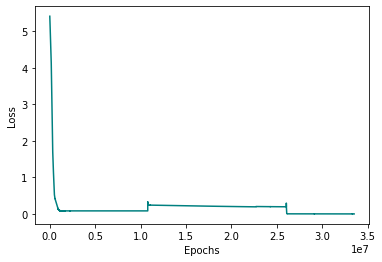

In [3]:
%%time

#this worked best
dinn = DINN(dengue_data[0], dengue_data[1], dengue_data[2], dengue_data[3], dengue_data[4], dengue_data[5], dengue_data[6], dengue_data[7]) 

learning_rate = 1e-3
optimizer = optim.Adam(dinn.params, lr = learning_rate)
dinn.optimizer = optimizer

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(dinn.optimizer, factor=0.85, patience = 5000, verbose=True)
#scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-6, max_lr=1e-3, step_size_up=100, mode="triangular2", cycle_momentum=False)
scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-7, max_lr=1e-3, step_size_up=1000, mode="exp_range", gamma=0.85, cycle_momentum=False)

dinn.scheduler = scheduler

try: 
  Sh_pred_list, Eh_pred_list, Ih_pred_list, Rh_pred_list, Sv_pred_list, Ev_pred_list, Iv_pred_list = dinn.train(1) #train
except EOFError:
  if dinn.save == 2:
    dinn.save = 3
    Sh_pred_list, Eh_pred_list, Ih_pred_list, Rh_pred_list, Sv_pred_list, Ev_pred_list, Iv_pred_list = dinn.train(1) #train
  elif dinn.save == 3:
    dinn.save = 2
    Sh_pred_list, Eh_pred_list, Ih_pred_list, Rh_pred_list, Sv_pred_list, Ev_pred_list, Iv_pred_list = dinn.train(1) #train

Text(0, 0.5, 'Loss')

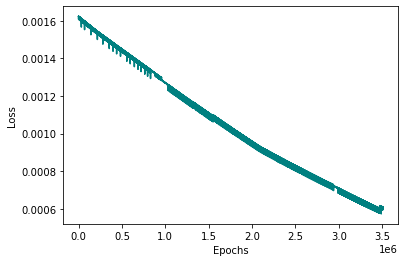

In [4]:
plt.plot(dinn.losses[30000000:], color = 'teal')
plt.xlabel('Epochs')
plt.ylabel('Loss')

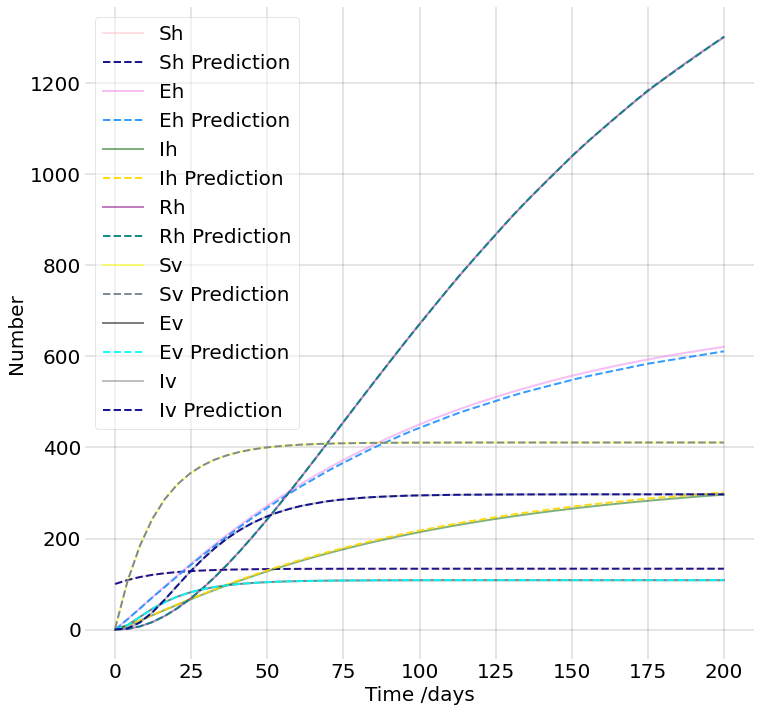

In [5]:
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')

ax.plot(dengue_data[0], dengue_data[1], 'pink', alpha=0.5, lw=2, label='Sh')
ax.plot(dengue_data[0], Sh_pred_list[0].detach().numpy(), 'navy', alpha=0.9, lw=2, label='Sh Prediction', linestyle='dashed')

ax.plot(dengue_data[0], dengue_data[2], 'violet', alpha=0.5, lw=2, label='Eh')
ax.plot(dengue_data[0], Eh_pred_list[0].detach().numpy(), 'dodgerblue', alpha=0.9, lw=2, label='Eh Prediction', linestyle='dashed')

ax.plot(dengue_data[0], dengue_data[3], 'darkgreen', alpha=0.5, lw=2, label='Ih')
ax.plot(dengue_data[0], Ih_pred_list[0].detach().numpy(), 'gold', alpha=0.9, lw=2, label='Ih Prediction', linestyle='dashed')

ax.plot(dengue_data[0], dengue_data[4], 'purple', alpha=0.5, lw=2, label='Rh')
ax.plot(dengue_data[0], Rh_pred_list[0].detach().numpy(), 'teal', alpha=0.9, lw=2, label='Rh Prediction', linestyle='dashed')

ax.plot(dengue_data[0], dengue_data[5], 'yellow', alpha=0.5, lw=2, label='Sv')
ax.plot(dengue_data[0], Sv_pred_list[0].detach().numpy(), 'slategrey', alpha=0.9, lw=2, label='Sv Prediction', linestyle='dashed')

ax.plot(dengue_data[0], dengue_data[6], 'black', alpha=0.5, lw=2, label='Ev')
ax.plot(dengue_data[0], Ev_pred_list[0].detach().numpy(), 'aqua', alpha=0.9, lw=2, label='Ev Prediction', linestyle='dashed')

ax.plot(dengue_data[0], dengue_data[7], 'grey', alpha=0.5, lw=2, label='Iv')
ax.plot(dengue_data[0], Iv_pred_list[0].detach().numpy(), 'darkblue', alpha=0.9, lw=2, label='Iv Prediction', linestyle='dashed')


ax.set_xlabel('Time /days',size = 20)
ax.set_ylabel('Number',size = 20)
#ax.set_ylim([-1,50])
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
plt.xticks(size = 20)
plt.yticks(size = 20)
ax.grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax.legend(prop={'size':20})
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.savefig('dengue.pdf')
plt.show()

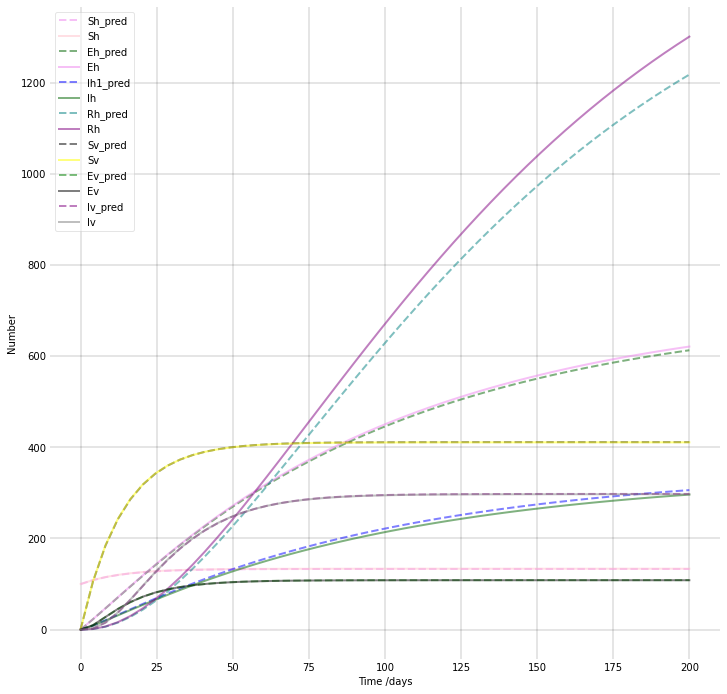

In [6]:
#vaccination! 

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Initial conditions

Sh0 = 100
Eh0 = 0
Ih = 0
Rh0 = 0
Sv0 = 1
Ev0 = 0 
Iv0 = 0

# A grid of time points (in days)
t = np.linspace(0, 200, 50) 

#parameters
pi_h = dinn.pi_h
pi_v = dinn.pi_v
lambdda_h = dinn.lambdda_h
lambdda_v = dinn.lambdda_v
delta_h = dinn.delta_h
delta_v = dinn.delta_v
mu_h = dinn.mu_h
mu_v = dinn.mu_v
sigma_h = dinn.sigma_h
sigma_v = dinn.sigma_v
tao_h = dinn.tao_h


# The SIR model differential equations.
def deriv(y, t, pi_h ,pi_v ,lambdda_h ,lambdda_v ,delta_h ,delta_v ,mu_h ,mu_v ,sigma_h ,sigma_v ,tao_h):
    Sh ,Eh ,Ih ,Rh ,Sv ,Ev ,Iv = y
    dShdt = pi_h - lambdda_h * Sh - mu_h * Sh
    dEhdt = lambdda_h * Sh - (sigma_h * mu_h) * Eh
    dIhdt = sigma_h * Eh - (tao_h + mu_h + delta_h) * Ih
    dRhdt = tao_h * Ih - mu_h * Rh
    dSvdt = pi_v - delta_v * Sv - mu_v * Sv
    dEvdt = delta_v * Sv - (sigma_v + mu_v) * Ev
    dIvdt = sigma_v * Ev - (mu_v + delta_v) * Iv

    return dShdt,dEhdt,dIhdt,dRhdt,dSvdt,dEvdt, dIvdt


# Initial conditions vector
y0 = Sh0 ,Eh0 ,Ih ,Rh0 ,Sv0 ,Ev0 ,Iv0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(pi_h ,pi_v ,lambdda_h ,lambdda_v ,delta_h ,delta_v ,mu_h ,mu_v ,sigma_h ,sigma_v ,tao_h))
Sh ,Eh ,Ih ,Rh ,Sv ,Ev ,Iv = ret.T

# Plot the data on two separate curves for S(t), I(t)
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')

ax.plot(t, Sh, 'violet', alpha=0.5, lw=2, label='Sh_pred', linestyle='dashed')
ax.plot(dengue_data[0], dengue_data[1], 'pink', alpha=0.5, lw=2, label='Sh')

ax.plot(t, Eh, 'darkgreen', alpha=0.5, lw=2, label='Eh_pred', linestyle='dashed')
ax.plot(dengue_data[0], dengue_data[2], 'violet', alpha=0.5, lw=2, label='Eh')

ax.plot(t, Ih, 'blue', alpha=0.5, lw=2, label='Ih1_pred', linestyle='dashed')
ax.plot(dengue_data[0], dengue_data[3], 'darkgreen', alpha=0.5, lw=2, label='Ih')

ax.plot(t, Rh, 'teal', alpha=0.5, lw=2, label='Rh_pred', linestyle='dashed')
ax.plot(dengue_data[0], dengue_data[4], 'purple', alpha=0.5, lw=2, label='Rh')

ax.plot(t, Sv, 'black', alpha=0.5, lw=2, label='Sv_pred', linestyle='dashed')
ax.plot(dengue_data[0], dengue_data[5], 'yellow', alpha=0.5, lw=2, label='Sv')

ax.plot(t, Ev, 'green', alpha=0.5, lw=2, label='Ev_pred', linestyle='dashed')
ax.plot(dengue_data[0], dengue_data[6], 'black', alpha=0.5, lw=2, label='Ev')

ax.plot(t, Iv, 'purple', alpha=0.5, lw=2, label='Iv_pred', linestyle='dashed')
ax.plot(dengue_data[0], dengue_data[7], 'grey', alpha=0.5, lw=2, label='Iv')


ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [7]:
#calculate relative MSE loss
import math

Sh_total_loss = 0 
Sh_den = 0
Eh_total_loss = 0 
Eh_den = 0
Ih_total_loss = 0 
Ih_den = 0
Rh_total_loss = 0 
Rh_den = 0
Sv_total_loss = 0 
Sv_den = 0
Ev_total_loss = 0 
Ev_den = 0
Iv_total_loss = 0 
Iv_den = 0

for timestep in range(len(t)):
    Sh_value = dengue_data[1][timestep] - Sh[timestep]
    Sh_total_loss += Sh_value**2
    Sh_den += (dengue_data[1][timestep])**2

    Eh_value = dengue_data[2][timestep] - Eh[timestep]
    Eh_total_loss += Eh_value**2
    Eh_den += (dengue_data[2][timestep])**2

    Ih_value = dengue_data[3][timestep] - Ih[timestep]
    Ih_total_loss += Ih_value**2
    Ih_den += (dengue_data[3][timestep])**2

    Rh_value = dengue_data[4][timestep] - Rh[timestep]
    Rh_total_loss += Rh_value**2
    Rh_den += (dengue_data[4][timestep])**2

    Sv_value = dengue_data[5][timestep] - Sv[timestep]
    Sv_total_loss += Sv_value**2
    Sv_den += (dengue_data[5][timestep])**2

    Ev_value = dengue_data[6][timestep] - Ev[timestep]
    Ev_total_loss += Ev_value**2
    Ev_den += (dengue_data[6][timestep])**2

    Iv_value = dengue_data[7][timestep] - Iv[timestep]
    Iv_total_loss += Iv_value**2
    Iv_den += (dengue_data[7][timestep])**2


Sh_total_loss = math.sqrt(Sh_total_loss/Sh_den)
print('Sh_total_loss', Sh_total_loss)
Eh_total_loss = math.sqrt(Eh_total_loss/Eh_den)
print('Eh_total_loss', Eh_total_loss)
Ih_total_loss = math.sqrt(Ih_total_loss/Ih_den)
print('Ih_total_loss', Ih_total_loss)
Rh_total_loss = math.sqrt(Rh_total_loss/Rh_den)
print('Rh_total_loss', Rh_total_loss)
Sv_total_loss = math.sqrt(Sv_total_loss/Sv_den)
print('Sv_total_loss', Sv_total_loss)
Ev_total_loss = math.sqrt(Ev_total_loss/Ev_den)
print('Ev_total_loss', Ev_total_loss)
Iv_total_loss = math.sqrt(Iv_total_loss/Iv_den)
print('Iv_total_loss', Iv_total_loss)

Sh_total_loss 0.0037426155606699136
Eh_total_loss 0.01153548760112262
Ih_total_loss 0.035024588648943575
Rh_total_loss 0.0632890791252662
Sv_total_loss 0.001152162000284345
Ev_total_loss 0.0015828407740973416
Iv_total_loss 0.002126838207659678
